In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [2]:
!mkdir -p ~/.kaggle  # Ensure the directory exists
!cp /kaggle/input/miller/kaggle.json ~/.kaggle/  # Copy the file
!chmod 600 ~/.kaggle/kaggle.json  # Set correct permissions

In [3]:
!kaggle competitions list

ref                                                                               deadline             category                reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-2     2025-04-01 23:59:00  Featured         2,117,152 Usd       1805           False  
https://www.kaggle.com/competitions/konwinski-prize                               2025-03-12 23:59:00  Featured         1,225,000 Usd        546           False  
https://www.kaggle.com/competitions/stanford-rna-3d-folding                       2025-05-29 23:59:00  Featured            75,000 Usd        294           False  
https://www.kaggle.com/competitions/byu-locating-bacterial-flagellar-motors-2025  2025-06-04 23:59:00  Research            65,000 Usd         11           False  
https://www.kaggle.com

In [4]:
!kaggle competitions download -c millers-planet

 99%|██████████████████████████████████████▋| 2.58G/2.59G [00:25<00:00, 143MB/s]
100%|███████████████████████████████████████| 2.59G/2.59G [00:25<00:00, 109MB/s]


In [5]:
import zipfile

competition_name = "millers-planet"
with zipfile.ZipFile(f"{competition_name}.zip", 'r') as zip_ref:
    zip_ref.extractall("/kaggle/working/")

In [6]:
train_csv_path = "/kaggle/working/train_gt.csv"

train_df = pd.read_csv(train_csv_path)
train_df['square_count'].value_counts()

square_count
2    532
3    488
1    362
4    344
5    132
0     95
6     42
7      3
8      2
Name: count, dtype: int64

In [7]:
image_folder = "/kaggle/working/train/train"
train_df["file_name"] = train_df["file_name"].apply(lambda x: os.path.join(image_folder, x))

print(train_df.head())

                               file_name  square_count
0  /kaggle/working/train/train/img_1.png             3
1  /kaggle/working/train/train/img_2.png             3
2  /kaggle/working/train/train/img_3.png             3
3  /kaggle/working/train/train/img_4.png             3
4  /kaggle/working/train/train/img_5.png             2


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

## Detect triangles and mask them

In [14]:
def detect_and_mask_squares(image, min_area=100, max_area=10000, square_threshold=0.05, blur_kernel=(5,5)):
    """
    Detects and masks squares in a grayscale image using OpenCV.
    
    Args:
        image: Input grayscale image (numpy array)
        min_area: Minimum contour area to consider
        max_area: Maximum contour area to consider
        square_threshold: Tolerance for square detection
        blur_kernel: Kernel size for Gaussian blur preprocessing
    
    Returns:
        tuple: (processed_image, mask, visualization, square_count)
    """
    processed = image.copy()
    
    square_mask = np.zeros_like(image)
    
    blurred = cv2.GaussianBlur(image, blur_kernel, 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create visualization image
    visualization = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
    
    # Analyze each contour
    squares_found = 0
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < min_area or area > max_area:
            continue
        
        # Approximate the contour
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, square_threshold * perimeter, True)
        
        # Check if it's a square/rectangle (4 vertices)
        if len(approx) == 4:
            # Additional check to distinguish between rectangles and other quadrilaterals
            # A square/rectangle should have roughly equal angles (~90 degrees)
            angles = []
            for i in range(4):
                p1 = approx[i][0]
                p2 = approx[(i+1) % 4][0]
                p3 = approx[(i+2) % 4][0]
                
                # Calculate vectors
                v1 = [p2[0] - p1[0], p2[1] - p1[1]]
                v2 = [p3[0] - p2[0], p3[1] - p2[1]]
                
                # Calculate dot product and magnitudes
                dot = v1[0]*v2[0] + v1[1]*v2[1]
                mag1 = np.sqrt(v1[0]**2 + v1[1]**2)
                mag2 = np.sqrt(v2[0]**2 + v2[1]**2)
                
                # Calculate angle in degrees
                if mag1 * mag2 == 0:
                    continue
                    
                cos_angle = dot / (mag1 * mag2)
                # Clamp to avoid domain errors due to floating point precision
                cos_angle = max(min(cos_angle, 1.0), -1.0)
                angle = np.degrees(np.arccos(cos_angle))
                angles.append(angle)
            
            # Check if angles are approximately 90 degrees (within tolerance)
            is_square = len(angles) == 4 and all(abs(angle - 90) < 20 for angle in angles)
            
            if is_square:
                # Draw square on the mask
                cv2.drawContours(square_mask, [contour], 0, 255, -1)
                
                # Draw square on visualization (blue)
                cv2.drawContours(visualization, [contour], 0, (255, 0, 0), 2)
                # Add a label
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    cv2.putText(visualization, "Square", (cx-20, cy), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
                
                squares_found += 1
            else:
                # Draw non-square quadrilateral on visualization (yellow)
                cv2.drawContours(visualization, [contour], 0, (0, 255, 255), 1)
                # Label
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    cv2.putText(visualization, "Quad", (cx-20, cy), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
        else:
            # Draw other contours on visualization (green)
            cv2.drawContours(visualization, [contour], 0, (0, 255, 0), 1)
            # Label with vertex count
            vertices = len(approx)
            label = f"{vertices}-sided"
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                cv2.putText(visualization, label, (cx-20, cy), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Remove squares from the original image
    processed[square_mask > 0] = 0
    
    print(f"Detected {squares_found} squares")
    
    return processed, square_mask, visualization, squares_found

In [15]:
from pathlib import Path

def process_image_file(file_path, output_dir=None, show_results=True):
    """
    Process an image file to detect and mask squares.
    
    Args:
        file_path: Path to the image file
        output_dir: Directory to save results (None = same as input)
        show_results: Whether to display results
    
    Returns:
        int: Number of squares detected
    """
    # Read the image
    file_path = Path(file_path)
    image = cv2.imread(str(file_path), cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Failed to load image: {file_path}")
        return 0
    
    # Process the image
    processed, mask, visualization, square_count = detect_and_mask_squares(image)
    
    # Create output directory if needed
    if output_dir is None:
        output_dir = file_path.parent
    else:
        output_dir = Path(output_dir)
        output_dir.mkdir(exist_ok=True, parents=True)
    
    # Save results
    base_name = file_path.stem
    cv2.imwrite(str(output_dir / f"{base_name}_processed.png"), processed)
    cv2.imwrite(str(output_dir / f"{base_name}_mask.png"), mask)
    cv2.imwrite(str(output_dir / f"{base_name}_visualization.png"), visualization)
    
    # Display results if requested
    if show_results:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(141)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Square Mask ({square_count} found)')
        plt.axis('off')
        
        plt.subplot(143)
        plt.imshow(processed, cmap='gray')
        plt.title('Squares Removed')
        plt.axis('off')
        
        plt.subplot(144)
        plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
        plt.title('Visualization')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return square_count

Detected 5 squares


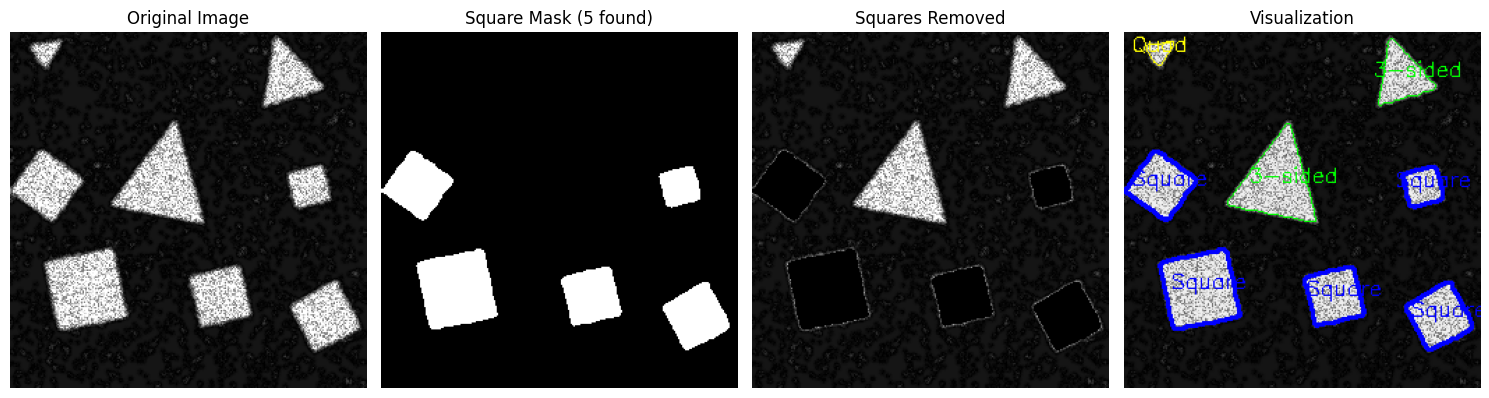

In [24]:
count = process_image_file('/kaggle/working/train/train/img_6.png')

## Predict number of squares

In [18]:
def predict_image(file_path,min_area=100, max_area=10000, square_threshold=0.05, blur_kernel=(5,5)):
    file_path = Path(file_path)
    image = cv2.imread(str(file_path), cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Failed to load image: {file_path}")
        return 0
    
    blurred = cv2.GaussianBlur(image, blur_kernel, 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    squares_found = 0
    
    for contour in contours:
        # Filter by area
        area = cv2.contourArea(contour)
        if area < min_area or area > max_area:
            continue
        
        # Approximate the contour
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, square_threshold * perimeter, True)
        if len(approx) == 4:
            # Additional check to distinguish between rectangles and other quadrilaterals
            # A square/rectangle should have roughly equal angles (~90 degrees)
            angles = []
            for i in range(4):
                p1 = approx[i][0]
                p2 = approx[(i+1) % 4][0]
                p3 = approx[(i+2) % 4][0]
                
                # Calculate vectors
                v1 = [p2[0] - p1[0], p2[1] - p1[1]]
                v2 = [p3[0] - p2[0], p3[1] - p2[1]]
                
                # Calculate dot product and magnitudes
                dot = v1[0]*v2[0] + v1[1]*v2[1]
                mag1 = np.sqrt(v1[0]**2 + v1[1]**2)
                mag2 = np.sqrt(v2[0]**2 + v2[1]**2)
                
                # Calculate angle in degrees
                if mag1 * mag2 == 0:
                    continue
                    
                cos_angle = dot / (mag1 * mag2)
                # Clamp to avoid domain errors due to floating point precision
                cos_angle = max(min(cos_angle, 1.0), -1.0)
                angle = np.degrees(np.arccos(cos_angle))
                angles.append(angle)
            
            # Check if angles are approximately 90 degrees (within tolerance)
            is_square = len(angles) == 4 and all(abs(angle - 90) < 20 for angle in angles)

            if is_square == 1:
                squares_found+=1
        


    return squares_found

In [25]:
prediction = predict_image('/kaggle/working/train/train/img_6.png')
print(prediction)

5


In [21]:
from sklearn.metrics import mean_absolute_error, accuracy_score

train_df["predicted_count"] = train_df["file_name"].apply(predict_image)

y_true = train_df["square_count"].values
y_pred = train_df["predicted_count"].values

mae = mean_absolute_error(y_true, y_pred)
exact_match_acc = accuracy_score(y_true, y_pred) * 100 
tolerance_acc = np.mean(np.abs(y_true - y_pred) <= 1) * 100 

In [22]:
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Exact Match Accuracy: {exact_match_acc:.2f}%")
print(f"Tolerance-Based Accuracy (±1 count): {tolerance_acc:.2f}%")

Mean Absolute Error (MAE): 0.00
Exact Match Accuracy: 100.00%
Tolerance-Based Accuracy (±1 count): 100.00%


In [23]:
mismatches = train_df[train_df["square_count"] != train_df["predicted_count"]]
print(mismatches[["file_name", "square_count", "predicted_count"]])

Empty DataFrame
Columns: [file_name, square_count, predicted_count]
Index: []


No mismatches

In [27]:
test_dir = "/kaggle/working/test/test" 
test_images = [f for f in os.listdir(test_dir) if f.endswith('.png')]

test_predictions = []

for file_name in test_images:
    image_path = os.path.join(test_dir, file_name)
    square_count = predict_image(image_path)
    test_predictions.append({"file_name": file_name, "square_count": square_count}) 

test_df = pd.DataFrame(test_predictions)

test_df.to_csv("test_predictions.csv", index=False)
print("\nPredictions saved to test_predictions.csv")

test_df.head()


Predictions saved to test_predictions.csv


,file_name,square_count
0,img_17011.png,5
1,img_17251.png,3
2,img_36168.png,4
3,img_28176.png,1
4,img_28517.png,3
